# Training deep chroma estimator with SDTW loss

Johannes Zeitler (johannes.zeitler@audiolabs-erlangen.de), 2023

Code base for ISMIR 2023 paper 

## 0. Setup & Parameters

In [1]:
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from time import time, gmtime, strftime
import torch 
import torch.nn.functional as F
from torchinfo import summary

from libdl.nn_models import *
from libdl.metrics import early_stopping
from libdl.training import Trainer
from libdl.data_loaders.parallelDataset import ParallelHCQTLoader 
from libdl.nn_losses.soft_dtw_cuda import SoftDTW

import libfmp.c5

### Set devices to use for training / testing

In [2]:
#device_train = 'cpu'
device_train = 'cuda:0'

#device_test = 'cpu'
device_test = 'cuda:0'

### General Parameters

In [3]:
batch_size = 32
num_targets = 500
gamma = 0.1
epochs = 3

# these 3 parameters are never modified
normalize = False
sharp = False
sharp_weight_by_avg_alignment_sum = False 


model_log_name = "SDTW_standard"
checkpoint_path = "../Logs/"

In [4]:
#For reviewing the results - print the used parameters
print(f'batch_size: {batch_size}')
print(f'num_targets: {num_targets}')
print(f'gamma: {gamma}')
print(f'normalize: {normalize}')
print(f'sharp: {sharp}')
print(f'sharp_weight_by_avg_alignment_sum: {sharp_weight_by_avg_alignment_sum}')

print(f'model_log_name: {model_log_name}')
print(f'checkpoint_path: {checkpoint_path}')

batch_size: 32
num_targets: 500
gamma: 0.1
normalize: False
sharp: False
sharp_weight_by_avg_alignment_sum: False
model_log_name: SDTW_standard
checkpoint_path: ../Logs/


### Set directory where to load data and save trained models

In [5]:
data_path = "../Data/Schubert_Winterreise_hcqt"

model_log_dir = os.path.join(checkpoint_path, model_log_name)
model_ckp_dir = os.path.join(model_log_dir, 'checkpoints')

os.makedirs(model_log_dir, exist_ok=True)
os.makedirs(model_ckp_dir, exist_ok=True)

### MSE cost function

In [6]:
def euclidean_dist_func(x, y):
    n = x.size(1)
    m = y.size(1)
    d = x.size(2)
    x = x.unsqueeze(2).expand(-1, n, m, d)
    y = y.unsqueeze(1).expand(-1, n, m, d)
    return torch.pow(x - y, 2).sum(3)

## 1. Training Strategy

Choose one of the following 5 training strategies

In [7]:
#strategy = "strongTargets"
strategy = "standardSDTW"
#strategy = "hypScheduling"
#strategy = "diagPrior"
#strategy = "unfolding"

In [8]:
# Strong Targets
if strategy == "strongTargets":    
    weak_labels = False # do not remove all target vector repetitions
    expand_weak_labels = False # no sequence unfolding
    plot_e_matrix = False
    crit = torch.nn.MSELoss()
    gamma_schedule=None
    D_prior_params=None
    split_loss_weakLabels = False
    lr_scheduler_start = 0

# Standard SDTW
elif strategy == "standardSDTW":
    weak_labels = True # remove all target vector repetitions
    expand_weak_labels = False # no sequence unfolding
    plot_e_matrix=True
    crit = SoftDTW(use_cuda=True, gamma=gamma, dist_func=euclidean_dist_func, normalize=normalize, sharp=sharp, sharp_weight_by_avg_alignment_sum=sharp_weight_by_avg_alignment_sum)
    gamma_schedule=None
    D_prior_params=None
    split_loss_weakLabels = True
    lr_scheduler_start = 0

# Strategy 1: Hyperparameter Scheduling
elif strategy == "hypScheduling":
    weak_labels = True # remove all target vector repetitions
    expand_weak_labels = False # no sequence unfolding
    plot_e_matrix=True
    crit = SoftDTW(use_cuda=True, gamma=gamma, dist_func=euclidean_dist_func, normalize=normalize, sharp=sharp, sharp_weight_by_avg_alignment_sum=sharp_weight_by_avg_alignment_sum)
    gamma_schedule={"initial_gamma":10.,
                    "steps_const": 10,
                    "steps_decay": 10,
                    "final_gamma":0.1}
    D_prior_params=None
    split_loss_weakLabels = True
    lr_scheduler_start = 21

# Strategy 2: Diagonal Prior
elif strategy == "diagPrior":
    weak_labels = True # remove all target vector repetitions
    expand_weak_labels = False # no sequence unfolding
    plot_e_matrix=True
    crit = SoftDTW(use_cuda=True, gamma=gamma, dist_func=euclidean_dist_func, normalize=normalize, sharp=sharp, sharp_weight_by_avg_alignment_sum=sharp_weight_by_avg_alignment_sum)
    gamma_schedule=None
    D_prior_params={"initial_weight": 3,
                    "final_weight": 0,
                    "steps_const" : 5,
                    "steps_decay": 5,
                    "nu": 1e3}  
    split_loss_weakLabels = True
    lr_scheduler_start = 0

# Strategy 3: Sequence Unfolding
elif strategy == "unfolding":
    weak_labels = True #  remove all target vector repetitions
    expand_weak_labels = True # strategy: sequence unfolding
    plot_e_matrix=True
    crit = SoftDTW(use_cuda=True, gamma=gamma, dist_func=euclidean_dist_func, normalize=normalize, sharp=sharp, sharp_weight_by_avg_alignment_sum=sharp_weight_by_avg_alignment_sum)
    gamma_schedule=None
    D_prior_params=None
    split_loss_weakLabels = False
    lr_scheduler_start = 0
    
else:
    print("!!! Strategy not found !!!")

##  2. Create model

In [8]:
# Set model parameters
n_chan_input=5               # C
n_chan_layers=[20,20,10,1]   # N0, N1, N2, N3
n_bins_in=216                # P * B = 72 * 3
n_bins_out=12                # chromas
a_lrelu=0.3
p_dropout=0.2

model = basic_cnn_segm_sigmoid(n_chan_input, n_chan_layers, n_bins_in, n_bins_out, a_lrelu, p_dropout)

summary(model, input_size=(50, 5, 574, 216))       # batch x C x L x P*B

Layer (type:depth-idx)                   Output Shape              Param #
basic_cnn_segm_sigmoid                   [50, 1, 500, 12]          --
├─LayerNorm: 1-1                         [50, 574, 5, 216]         2,160
├─Sequential: 1-2                        [50, 20, 574, 216]        --
│    └─Conv2d: 2-1                       [50, 20, 574, 216]        22,520
│    └─LeakyReLU: 2-2                    [50, 20, 574, 216]        --
│    └─MaxPool2d: 2-3                    [50, 20, 574, 216]        --
│    └─Dropout: 2-4                      [50, 20, 574, 216]        --
├─Sequential: 1-3                        [50, 20, 574, 72]         --
│    └─Conv2d: 2-5                       [50, 20, 574, 72]         3,620
│    └─LeakyReLU: 2-6                    [50, 20, 574, 72]         --
│    └─MaxPool2d: 2-7                    [50, 20, 574, 72]         --
│    └─Dropout: 2-8                      [50, 20, 574, 72]         --
├─Sequential: 1-4                        [50, 10, 500, 72]         --
│    

## 3. Optimizer, learning rate scheduler, early stopping, loss function

In [9]:
if weak_labels:
    if expand_weak_labels:
        expand_type="unfold"
    else:
        expand_type="unique"
else:
    expand_type="strong"

In [10]:
path_trainer_ckp = model_ckp_dir

only_save_best = False

# optimizer parameters
op = {'name': 'Adam',
      'initial_lr': 0.001}

# learning rate scheduler parameters 
sp = {'use_scheduler': True,
      'name': 'ReduceLROnPlateau',
      'mode': 'min',
      'factor': 0.5,
      'patience': 4,
      'threshold': 1e-4,                 
      'threshold_mode': 'rel',
      'cooldown': 0,
      'min_lr': 1e-6,
      'eps': 1e-08,
      'verbose': False
      }

# early stopping parameters
ep = {'use_early_stopping': True,
      'mode': 'min',
      'min_delta': 1e-5,
      'patience': 12,
      'percentage': False
      }


ckp_prefix = 'nTargets%i_batchSize%i_lr%s_%s_normalize%s'%(num_targets,
                                                     batch_size,
                                                     str(op["initial_lr"]).replace(".", ""),
                                                     expand_type,
                                                     normalize)

In [11]:
logfile = os.path.join(model_log_dir, "modelInfo_"+ckp_prefix+".txt")
logfile_train = os.path.join(model_log_dir, "trainLog_"+ckp_prefix+".txt")

In [12]:
with open(logfile, "a") as lf:
    lf.write(f"{datetime.now()}\n")
    lf.write("#general params\n")
    lf.write(f'batch_size: {batch_size}\n')
    lf.write(f'num_targets: {num_targets}\n')
    lf.write(f'weak_labels: {weak_labels}\n')
    lf.write(f'expand_weak_labels: {expand_weak_labels}\n')
    lf.write(f'gamma: {gamma}\n')
    lf.write(f'normalize: {normalize}\n')
    lf.write(f'sharp: {sharp}\n')
    lf.write(f'sharp_weight_by_avg_alignment_sum: {sharp_weight_by_avg_alignment_sum}\n')
    
    lf.write("#op\n")
    for key in op.keys():
        lf.write(f"{key}: {op[key]}\n")
        
    lf.write("#sp\n")
    for key in sp.keys():
        lf.write(f"{key}: {sp[key]}\n")
        
    lf.write("#ep\n")
    for key in ep.keys():
        lf.write(f"{key}: {ep[key]}\n")


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=op['initial_lr'])


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=sp['mode'], \
        factor=sp['factor'], patience=sp['patience'], threshold=sp['threshold'], threshold_mode=sp['threshold_mode'], \
        cooldown=sp['cooldown'], eps=sp['eps'], min_lr=sp['min_lr'], verbose=sp['verbose'])

es = early_stopping(mode=ep['mode'], min_delta=ep['min_delta'], patience=ep['patience'], percentage=ep['percentage'])

## 4. Dataset

... modify this if you only have the publicly available versions (HU33, SC06)

In [14]:
train_versions = ['AL98', 'FI55', 'FI80', 'OL06', 'QU98']
val_versions = ['FI66', 'TR99']
test_versions = ['HU33', 'SC06']

In [15]:
fileList_train =  []
fileList_test =  []
fileList_val =  []


# only add files specified by train_versions
for f in os.listdir(data_path):
    if '.h5' in f:
        for version in train_versions:
            if version in f:
                fileList_train.append(os.path.join(data_path, f))
        for version in test_versions:
            if version in f:
                fileList_test.append(os.path.join(data_path, f))
        for version in val_versions:
            if version in f:
                fileList_val.append(os.path.join(data_path, f))
                
fileList_train.sort()
fileList_test.sort()
fileList_val.sort()

### create Data loaders (parallel HCQT loaders from .h5 files)

In [16]:
train_loader = ParallelHCQTLoader(fileList=fileList_train,
          segments_per_file=20, # always choose 20 random segments per file
          max_workers=8, 
          batch_size=batch_size,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=True,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=weak_labels,
          expand_weak_labels=expand_weak_labels)

val_loader = ParallelHCQTLoader(fileList=fileList_val,
          stride=200, # choose always the same segments from each file with a shift of 200
          max_workers=8, 
          batch_size=batch_size,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=True,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=weak_labels,
          expand_weak_labels=expand_weak_labels)


test_loader = ParallelHCQTLoader(fileList=fileList_test,
          stride=100, # choose always the same segments from each file with a shift of 100
          max_workers=8, 
          batch_size=batch_size,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=weak_labels,
          expand_weak_labels=expand_weak_labels)

test_loader_strong = ParallelHCQTLoader(fileList=fileList_test,
          stride=100, # choose always the same segments from each file with a shift of 100
          max_workers=8, 
          batch_size=batch_size,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=False,
          expand_weak_labels=expand_weak_labels)

### dataloader for inspection of E-matrix

In [17]:
plot_loader = ParallelHCQTLoader(fileList=fileList_val[:16], # choose 16 files from the validation set for plotting the E-matrix
          target_indices=[2000], # always plot the same snippet
          max_workers=16, 
          batch_size=16,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=weak_labels,
          expand_weak_labels=expand_weak_labels)


plot_loader_strong = ParallelHCQTLoader(fileList=fileList_val[:16], # choose 16 files from the validation set for plotting the E-matrix
          target_indices=[2000], # always plot the same snippet
          max_workers=16, 
          batch_size=16,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=False,
          expand_weak_labels=expand_weak_labels)

### generate samples to be displayed after each training epoch

In [18]:
for (x,y), (_, y_strong) in zip(plot_loader, plot_loader_strong):
    break
            

x = x.to(device_train)
y = y.to(device_train)

changes = (y[:, :, 1:, :] != y[:, :, :-1, :]).any(axis=3)
lastChange = torch.sum(changes, axis=[1,2])

opt_paths = []

for b in range(y.shape[0]):
    target = y_strong[b]

    nReps = []
    new_target = None
    last_target = None

    nReps.append(1)
    for frame in range(target.shape[1]):
        # first frame
        if frame == 0:
            new_target = target[:,frame,:]
            last_target = target[:,frame,:]
            continue   
        # check if new label
        if not np.array_equal(target[:,frame,:], last_target):
            last_target = target[:,frame,:]
            new_target = np.concatenate((new_target,last_target),0)
            nReps.append(1)
        else:
            nReps[-1] += 1

    plotx = []
    ploty = [0]
    for i, rep in enumerate(nReps):
        plotx.append(i)
        ploty.append(ploty[-1]+rep)    
        plotx.append(i)
        ploty.append(ploty[-1])
    ploty.pop()
    
    opt_paths.append((plotx, ploty))

In [19]:
plot_e_matrix_params={"x":x,
                      "y":y,
                      "opt_paths":opt_paths,
                      "lastChange":lastChange}

## 5. Create trainer + train model

In [20]:
if not os.path.exists(model_ckp_dir):
    os.mkdir(model_ckp_dir)

trainer = Trainer(model, 
                  crit,
                  optim=optimizer,
                  lr_schedule=scheduler,
                  early_stop=es,                        
                  train_dl=train_loader,
                  val_dl=val_loader,
                  device=device_train,
                  path_trainer_ckp=model_ckp_dir,
                  ckp_prefix=ckp_prefix,
                  only_save_best=False,#save model after each checkpoint
                  verbose=True,
                  logfile = logfile_train,
                  split_loss_weakLabels = split_loss_weakLabels,#compute SDTW loss sequentially (as target sequences within a batch have different lengths)
                  plot_e_matrix=plot_e_matrix,
                  plot_e_matrix_params = plot_e_matrix_params,
                  gamma_schedule=gamma_schedule,
                  lr_scheduler_start = 0,# adjust this to (steps_const + steps_decay + 1) when using gamma scheduling!
                  D_prior_params=D_prior_params
                 )

### Train model

In [ ]:
train_losses = []

start = time()
train_losses, val_losses = trainer.fit(epochs=epochs)
training_dur = time() - start

In [22]:
training_dur_formatted = strftime('%H:%M:%S', gmtime(training_dur))
print(f'Training duration: {training_dur_formatted} [hh:mm:ss]')

Training duration: 00:02:02 [hh:mm:ss]


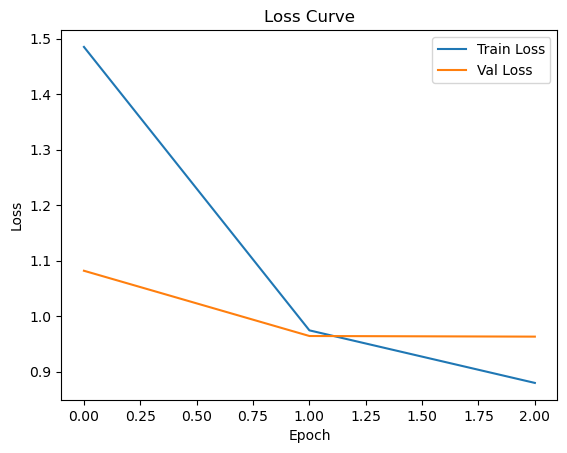

In [24]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

## 6. Test stage

### quantitative evaluation on test set

In [25]:
all_labels = []
all_preds = []
model.eval()
model.to(device_test)
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader_strong):
        x = x.to(device_test)
        all_labels.append(y)
        all_preds.append(model(x))

In [26]:
lastIdx = len(all_labels)
if all_labels[-1].shape[0] != all_labels[0].shape[0]:
    lastIdx -= 1

In [27]:
all_labels_concat = torch.stack(all_labels[:lastIdx]).cpu().numpy()
all_preds_concat = torch.stack(all_preds[:lastIdx]).cpu().numpy()

In [28]:
prec, rec, fmeas, _, _, _ = libfmp.c5.compute_eval_measures(all_labels_concat, all_preds_concat>.5)

print(f'\nPytorch - Trained Pipeline:')
print(f'{"Precision:" : <15}{prec : .3f}')
print(f'{"Recall:" : <15}{rec : .3f}')
print(f'{"F-measure:" : <15}{fmeas : .3f}')


Pytorch - Trained Pipeline:
Precision:      0.706
Recall:         0.900
F-measure:      0.791


### qualitative evaluation: visualize the elements within a batch

In [ ]:
nBatches_plot = 10
for i in range(nBatches_plot):
    list_labels = []
    list_preds = []
    for b in range(batch_size):
        list_labels.append(np.squeeze(all_labels_concat[i,b]))
        list_preds.append(np.squeeze(all_preds_concat[i,b]))


    fig, ax = plt.subplots(2, 1, figsize=(15, 4))
    ax[0].imshow(np.concatenate(list_labels, axis=0).T, origin='lower', aspect='auto', clim=[0,1], cmap='gray_r', interpolation="none")
    ax[1].imshow(np.concatenate(list_preds, axis=0).T, origin='lower', aspect='auto', clim=[0,1], cmap='gray_r', interpolation="none")

    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])

    ax[0].set_ylabel("chroma label")
    ax[1].set_ylabel("chroma pred.")
    fig.suptitle("batch %i"%(i))
